In [ ]:
! pip install -q qiskit
! pip install -q qiskit-aer
! pip install -q qiskit-algorithms
! pip install -q qiskit-nature
! pip install -q qiskit-nature-pyscf # install the pyscf library
! pip install -q qiskit-ibm-runtime
# print(qiskit.__version__)
# print(qiskit_aer.__version__)
# print(qiskit_algorithms.__version__)
# print(qiskit_nature.__version__)
# print(qiskit_nature_pyscf.__version__)
# print(qiskit_ibm_runtime.__version__)


In [122]:
import qiskit_nature
import qiskit
import qiskit_aer
import qiskit_algorithms
import qiskit_ibm_runtime
import qiskit_nature_pyscf
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit.circuit.library import EfficientSU2
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer import  AerSimulator
# from qiskit_nature.second_q.algorithms import VQEUCCFactory
from qiskit_algorithms.optimizers import SLSQP
from qiskit_aer.primitives import Estimator
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.problems import ElectronicBasis
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.mappers import ParityMapper
from scipy.linalg import eigh
from qiskit_nature.second_q.circuit.library import HartreeFock
from scipy.linalg import expm
from qiskit.quantum_info import Statevector
from numpy import pi

# Analysis of Li atom in 10 spin orbitals:

In [124]:
mdriver = PySCFDriver(
    atom="Li 0.0 0.0 0.0",  # Specify the atom and its coordinates
    basis="sto3g",          # Define the basis set
    charge=0,                # Set the charge of the atom
    spin=1,                 # Set the spin of the atom
    unit=DistanceUnit.ANGSTROM, # Define the unit of the coordinates
)

# You can now use the driver to run a calculation
electronic_structure_problem = mdriver.run()

In [125]:
print("Spatial orbitals:", electronic_structure_problem.num_spatial_orbitals)
print("Number of up spin: ", electronic_structure_problem.num_alpha)
print("Number of down spin: ", electronic_structure_problem.num_beta)
print("\n")
print("Down spin configuration : ", electronic_structure_problem.orbital_occupations_b)
print("Down spin configuration : ",electronic_structure_problem.orbital_occupations)
print("Number of particles: ", electronic_structure_problem.num_particles)
# print(electronic_structure_problem.second_q_ops()[0])

Spatial orbitals: 5
Number of up spin:  2
Number of down spin:  1


Down spin configuration :  [1. 0. 0. 0. 0.]
Down spin configuration :  [1. 1. 0. 0. 0.]
Number of particles:  (2, 1)


In [126]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper

solver = GroundStateEigensolver(
    JordanWignerMapper(),
    NumPyMinimumEigensolver(),
)

result = solver.solve(electronic_structure_problem)
print(result)
print("HF energy : ", electronic_structure_problem.reference_energy)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -7.315836552851
  - computed part:      -7.315836552851
~ Nuclear repulsion energy (Hartree): 0.0
> Total ground state energy (Hartree): -7.315836552851
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 3.000 S: 0.500 S^2: 0.750 M: 0.152
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 
HF energy :  -7.315525981281089


In [127]:
mapper = JordanWignerMapper()
qubit_hamiltonian = mapper.map(electronic_structure_problem.second_q_ops()[0])
state = HartreeFock(electronic_structure_problem.num_spatial_orbitals, electronic_structure_problem.num_particles, mapper)
print(state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
     ┌───┐
q_5: ┤ X ├
     └───┘
q_6: ─────
          
q_7: ─────
          
q_8: ─────
          
q_9: ─────
          


In [128]:
from qiskit_algorithms import NumPyEigensolver
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
numpy_solver = NumPyEigensolver(k=2, filter_criterion=electronic_structure_problem.get_default_filter_criterion())
numpy_excited_states_solver = ExcitedStatesEigensolver(mapper, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(electronic_structure_problem)
# print(numpy_results)

In [129]:
numpy_results.computed_energies

array([], dtype=float64)

In [130]:
statevector = Statevector(state)
k = 3
E_sub = np.zeros((k, k), dtype=complex)
S_sub = np.zeros((k, k), dtype=complex)
for i in range(k):
    for j in range(k):
        U = expm(-(i-j)*pi*1j*qubit_hamiltonian/0.08)

        # Apply the unitary operator to the statevector using evolve()
        evolved_statevector = statevector.evolve(U)

        # Now you can access the data of the evolved statevector
        S_sub[i, j] = statevector.expectation_value(U)

        # Now apply hamiltonian to evolved state
        evolved_statevector = evolved_statevector.evolve(qubit_hamiltonian)
        E_sub[i, j] = statevector.inner(evolved_statevector)

print(E_sub)
print(S_sub)


[[-7.31552598+0.j          1.19033506-7.21691474j  6.92746612+2.35002278j]
 [ 1.19033506+7.21691474j -7.31552598+0.j          1.19033506-7.21691474j]
 [ 6.92746612-2.35002278j  1.19033506+7.21691474j -7.31552598+0.j        ]]
[[ 1.        +0.j         -0.16269265+0.98644957j -0.94691923-0.32125274j]
 [-0.16269265-0.98644957j  1.        +0.j         -0.16269265+0.98644957j]
 [-0.94691923+0.32125274j -0.16269265-0.98644957j  1.        +0.j        ]]


In [131]:
# S_sub = regularize_matrix(S_sub)
eigenvalues, eigenvectors = eigh(E_sub, S_sub)
print(eigenvalues)
print(eigenvectors)
# print(eigenvalues[0]- eigenvalues[1])

[-7.31582811 -5.04744521 -3.15158127]
[[-2.99838934e-01+1.41717490e-01j  2.78362925e+01+1.12324556e+01j
  -1.15697778e+02-6.72269496e+00j]
 [ 6.51695637e-02+3.95044341e-01j  2.33861190e+01+3.14723661e+01j
   5.12364760e+01-1.82587365e+01j]
 [ 3.29470315e-01+3.79017787e-02j  2.72299400e+00+2.98933529e+01j
  -8.53717437e+01+7.83762456e+01j]]


In [132]:
# from qiskit_algorithms import VQE
# from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
# from qiskit.primitives import Estimator
# from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
# from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
# electronic_structure_problem = transformer.transform(electronic_structure_problem)
# ansatz = UCCSD(
#     electronic_structure_problem.num_spatial_orbitals,
#     electronic_structure_problem.num_particles,
#     mapper,
#     initial_state=HartreeFock(
#         electronic_structure_problem.num_spatial_orbitals,
#         electronic_structure_problem.num_particles,
#         mapper,
#     ),
# )

# estimator = Estimator()
# # This first part sets the ground state solver
# # see more about this part in the ground state calculation tutorial
# solver = VQE(estimator, ansatz, SPSA())
# solver.initial_point = [0.0] * ansatz.num_parameters
# gse = GroundStateEigensolver(mapper, solver)

# # The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
# qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
# qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)

In [133]:
# qeom_results.computed_energies

In [134]:
exact_eva, exact_eve = eigh(qubit_hamiltonian.to_matrix())
print(exact_eva)

[-7.31583655e+00 -7.31583655e+00 -7.25379126e+00 ... -4.90501018e-01
  1.64868119e-14  3.77428002e-01]


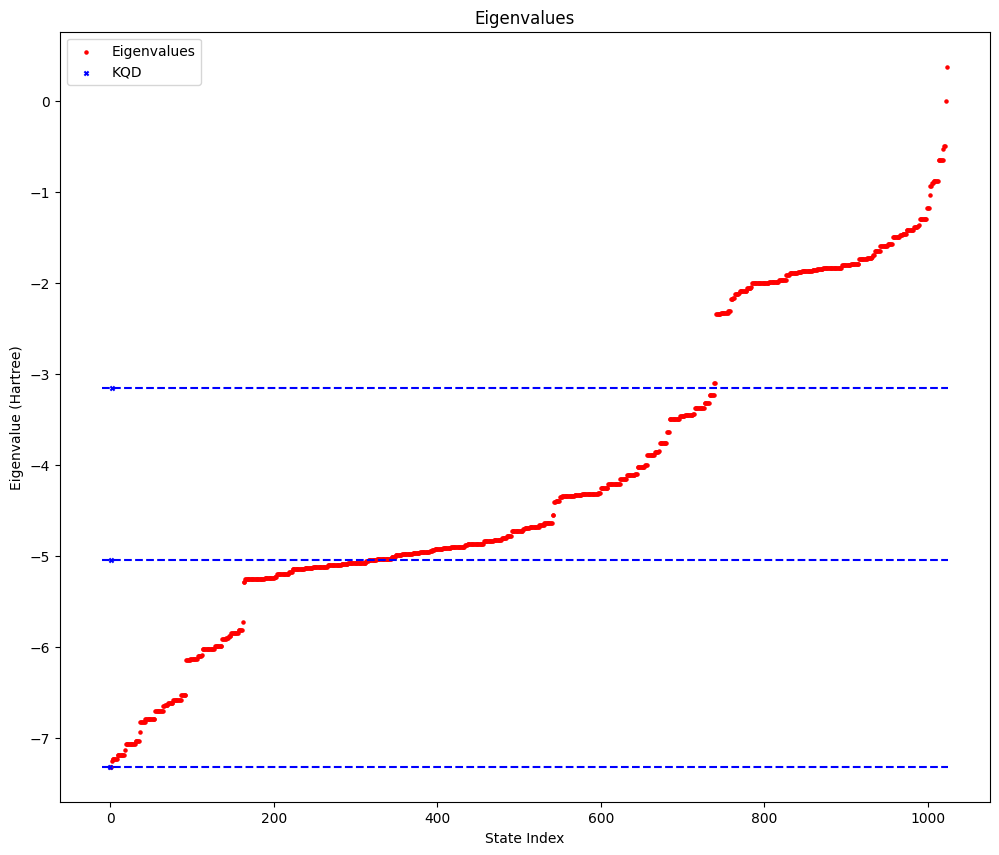

In [135]:
import matplotlib.pyplot as plt
import numpy as np


states = np.arange(len(exact_eva))  # Create state indices (0, 1, 2, ...)
kstate = np.arange(len(eigenvalues))

# Create a scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(states, exact_eva, color="red", label="Eigenvalues", marker="o", s=5)
plt.scatter(kstate, eigenvalues, color="blue", label="KQD", marker="x", s=9)
# Add labels and title
for val in eigenvalues:
    plt.hlines(y=val, xmin=-10, xmax=1024, colors='blue', linestyles='--', linewidth=1.5)

plt.xlabel("State Index")
plt.ylabel("Eigenvalue (Hartree)")
plt.title("Eigenvalues")
# plt.grid(True)
plt.legend()

# Show the plot
plt.show()


In [136]:
# from qiskit_algorithms import VQE
# from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
# from qiskit.primitives import Estimator
# from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
# from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
# electronic_structure_problem = transformer.transform(electronic_structure_problem)
# ansatz = UCCSD(
#     electronic_structure_problem.num_spatial_orbitals,
#     electronic_structure_problem.num_particles,
#     mapper,
#     initial_state=HartreeFock(
#         electronic_structure_problem.num_spatial_orbitals,
#         electronic_structure_problem.num_particles,
#         mapper,
#     ),
# )

# estimator = Estimator()
# # This first part sets the ground state solver
# # see more about this part in the ground state calculation tutorial
# solver = VQE(estimator, ansatz, COBYLA())
# solver.initial_point = [0.0] * ansatz.num_parameters
# gse = GroundStateEigensolver(mapper, solver)

# # The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
# qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
# qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)
# cobyla_energy = qeom_results.computed_energies
# cobyla_energy

In [137]:
# from qiskit_algorithms import VQE
# from qiskit_algorithms.optimizers import SLSQP, COBYLA, SPSA
# from qiskit.primitives import Estimator
# from qiskit_nature.second_q.algorithms import GroundStateEigensolver, QEOM, EvaluationRule
# from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD

# transformer = FreezeCoreTransformer(remove_orbitals=[3, 4], freeze_core=False)
# electronic_structure_problem = transformer.transform(electronic_structure_problem)
# ansatz = UCCSD(
#     electronic_structure_problem.num_spatial_orbitals,
#     electronic_structure_problem.num_particles,
#     mapper,
#     initial_state=HartreeFock(
#         electronic_structure_problem.num_spatial_orbitals,
#         electronic_structure_problem.num_particles,
#         mapper,
#     ),
# )

# estimator = Estimator()
# # This first part sets the ground state solver
# # see more about this part in the ground state calculation tutorial
# solver = VQE(estimator, ansatz, SLSQP())
# solver.initial_point = [0.0] * ansatz.num_parameters
# gse = GroundStateEigensolver(mapper, solver)

# # The qEOM algorithm is simply instantiated with the chosen ground state solver and Estimator primitive
# qeom_excited_states_solver = QEOM(gse, estimator, "sd", EvaluationRule.ALL)
# qeom_results = qeom_excited_states_solver.solve(electronic_structure_problem)
# slsqp_energy = qeom_results.computed_energies
# slsqp_energy

In [138]:
eigenvalues

array([-7.31582811, -5.04744521, -3.15158127])

In [139]:
# plt.figure(figsize=(14, 10))
# state = np.arange(len(slsqp_energy))
# plt.plot(state, slsqp_energy, color="red", label="slsqp_energy value", marker="o", linewidth=1.0, markersize=8)
# plt.plot(state, cobyla_energy, color="blue", label="cobyla_energy value", marker="x",  linewidth=1.0, markersize=8)
# plt.plot(state, spsa_energy, color="green", label="spsa_energy value", marker="^",  linewidth=1.0, markersize=8)
# plt.plot(kstate, eigenvalues, color="black", label="kqd_energy value", marker="*",  linewidth=1.0, markersize=8)
# plt.xlabel("State Index")
# plt.ylabel("Eigenvalue (Hartree)")
# plt.title("Eigenvalues")
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

In [140]:
print(eigenvectors.shape)
coeff_subspace = eigenvectors[0]

(3, 3)


In [141]:
from scipy.linalg import norm
# Here 10 is the number of spin orbitals to used in our calculation

psi_i = Statevector([0] *(2**10))
# print(norm(eigenvectors[0]))
for i in range(k):
    evolved_statevector = statevector.evolve(U)
    psi_i += eigenvectors[0][i] / norm(eigenvectors[0]) * evolved_statevector
print("Unnormalised state:", psi_i.data)
print("Norm of state:", abs(psi_i.inner(psi_i.conjugate())))
print("Ground state energy calculate from state:", psi_i.expectation_value(qubit_hamiltonian)/abs(psi_i.inner(psi_i.conjugate())))

Unnormalised state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Norm of state: 0.5438102182006126
Ground state energy calculate from state: (-7.31552598128107+0j)


In [142]:
psi_norm = abs(psi_i.inner(psi_i.conjugate()))
gs = psi_i/(psi_norm)**0.5
print("Normalised ground state:",gs.data)
print("Ground state energy:",gs.expectation_value(qubit_hamiltonian))
print(abs(gs.inner(gs.conjugate())))

Normalised ground state: [0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
Ground state energy: (-7.315525981281077+0j)
0.9999999999999999


In [147]:
gs_state = gs.to_dict()
gs_state

{'0000100011': (-0.9986110385129483+0.05268770027331635j)}

In [146]:
eigenvalues

array([-7.31582811, -5.04744521, -3.15158127])

In [144]:
y = gs_state["0000100011"]
y

(-0.9986110385129483+0.05268770027331635j)

In [145]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_complex_number(z):
#     # Create a unit circle
#     theta = np.linspace(0, 2 * np.pi, 500)
#     x = np.cos(theta)
#     y = np.sin(theta)

#     # Plot the unit circle
#     plt.figure(figsize=(6, 6))
#     plt.plot(x, y, label='state', color='blue')

#     # Plot the complex number
#     plt.scatter(z.real, z.imag, color='red', label=f'z = {z}')
#     plt.plot([0, z.real], [0, z.imag], color='red', linestyle='--', label='Vector to z')

#     # Add labels and grid
#     plt.axhline(0, color='black',linewidth=0.5)
#     plt.axvline(0, color='black',linewidth=0.5)
#     plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
#     # plt.legend()
#     plt.title('Statevector|0000100011>')
#     plt.xlabel('Real Part')
#     plt.ylabel('Imaginary Part')
#     plt.axis('equal')

#     # Show the plot
#     plt.show()

# # Example complex number (on or within the unit circle)
# plot_complex_number(y)
